# Model Selection

## Importing Libraries

In [1]:
# Import libraries
import warnings
import itertools
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import math
from datetime import date
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

%load_ext nb_black

# Defaults
plt.rcParams["figure.figsize"] = (20.0, 10.0)
plt.rcParams.update({"font.size": 12, "figure.dpi": 120})
# pd.set_option('display.max_rows', None)
warnings.filterwarnings("ignore")  # specify to ignore warning messages

<IPython.core.display.Javascript object>

## Data Handling

In [2]:
def preprocess(df):
    df = df.drop(["Lat", "Long"], axis=1)
    df = df.groupby(["Country/Region"], as_index=False).sum()
    df.loc[-1] = df.sum()
    df.loc[-1, "Country/Region"] = "Worldwide"
    countries = [
        "US",
        "Germany",
        "Spain",
        "United Kingdom",
        "France",
        "India",
        "Iran",
        "Italy",
        "Russia",
        "Turkey",
        #         "Worldwide",
    ]
    df = df.loc[df["Country/Region"].isin(countries)]
    df.reset_index(drop=True, inplace=True)
    df = df.set_index("Country/Region")
    df.columns = pd.to_datetime(df.columns)
    #   df.columns = pd.to_datetime(df.columns).dt.strftime('%d/%m/%Y')
    df = df.T
    return df

<IPython.core.display.Javascript object>

In [3]:
confirmed_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_confirmed_global.csv"
)
confirmed_df = preprocess(confirmed_df)
deaths_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_deaths_global.csv"
)
deaths_df = preprocess(deaths_df)
recovered_df = pd.read_csv(
    "./csse_covid_19_time_series/time_series_covid19_recovered_global.csv"
)
recovered_df = preprocess(recovered_df)

<IPython.core.display.Javascript object>

In [4]:
active_df = pd.DataFrame(confirmed_df - deaths_df - recovered_df)
confirmed_df[:"2021-08-6"].head()

Country/Region,France,Germany,India,Iran,Italy,Russia,Spain,Turkey,US,United Kingdom
2020-01-22,0,0,0,0,0,0,0,0,1,0
2020-01-23,0,0,0,0,0,0,0,0,1,0
2020-01-24,2,0,0,0,0,0,0,0,2,0
2020-01-25,3,0,0,0,0,0,0,0,2,0
2020-01-26,3,0,0,0,0,0,0,0,5,0


<IPython.core.display.Javascript object>

In [5]:
# confirmed_df.plot()

<IPython.core.display.Javascript object>

In [6]:
# deaths_df.plot()

<IPython.core.display.Javascript object>

In [7]:
# recovered_df.plot()

<IPython.core.display.Javascript object>

### Train test split

In [8]:
active_train = active_df["2020-01-22":"2021-04-22"]
active_test = active_df["2021-04-23":"2021-04-08"]
confirmed_train = confirmed_df["2020-01-22":"2021-04-22"]
confirmed_test = confirmed_df["2021-04-23":"2021-04-08"]

<IPython.core.display.Javascript object>

## Model Selection

### Determining order of differencing (d)

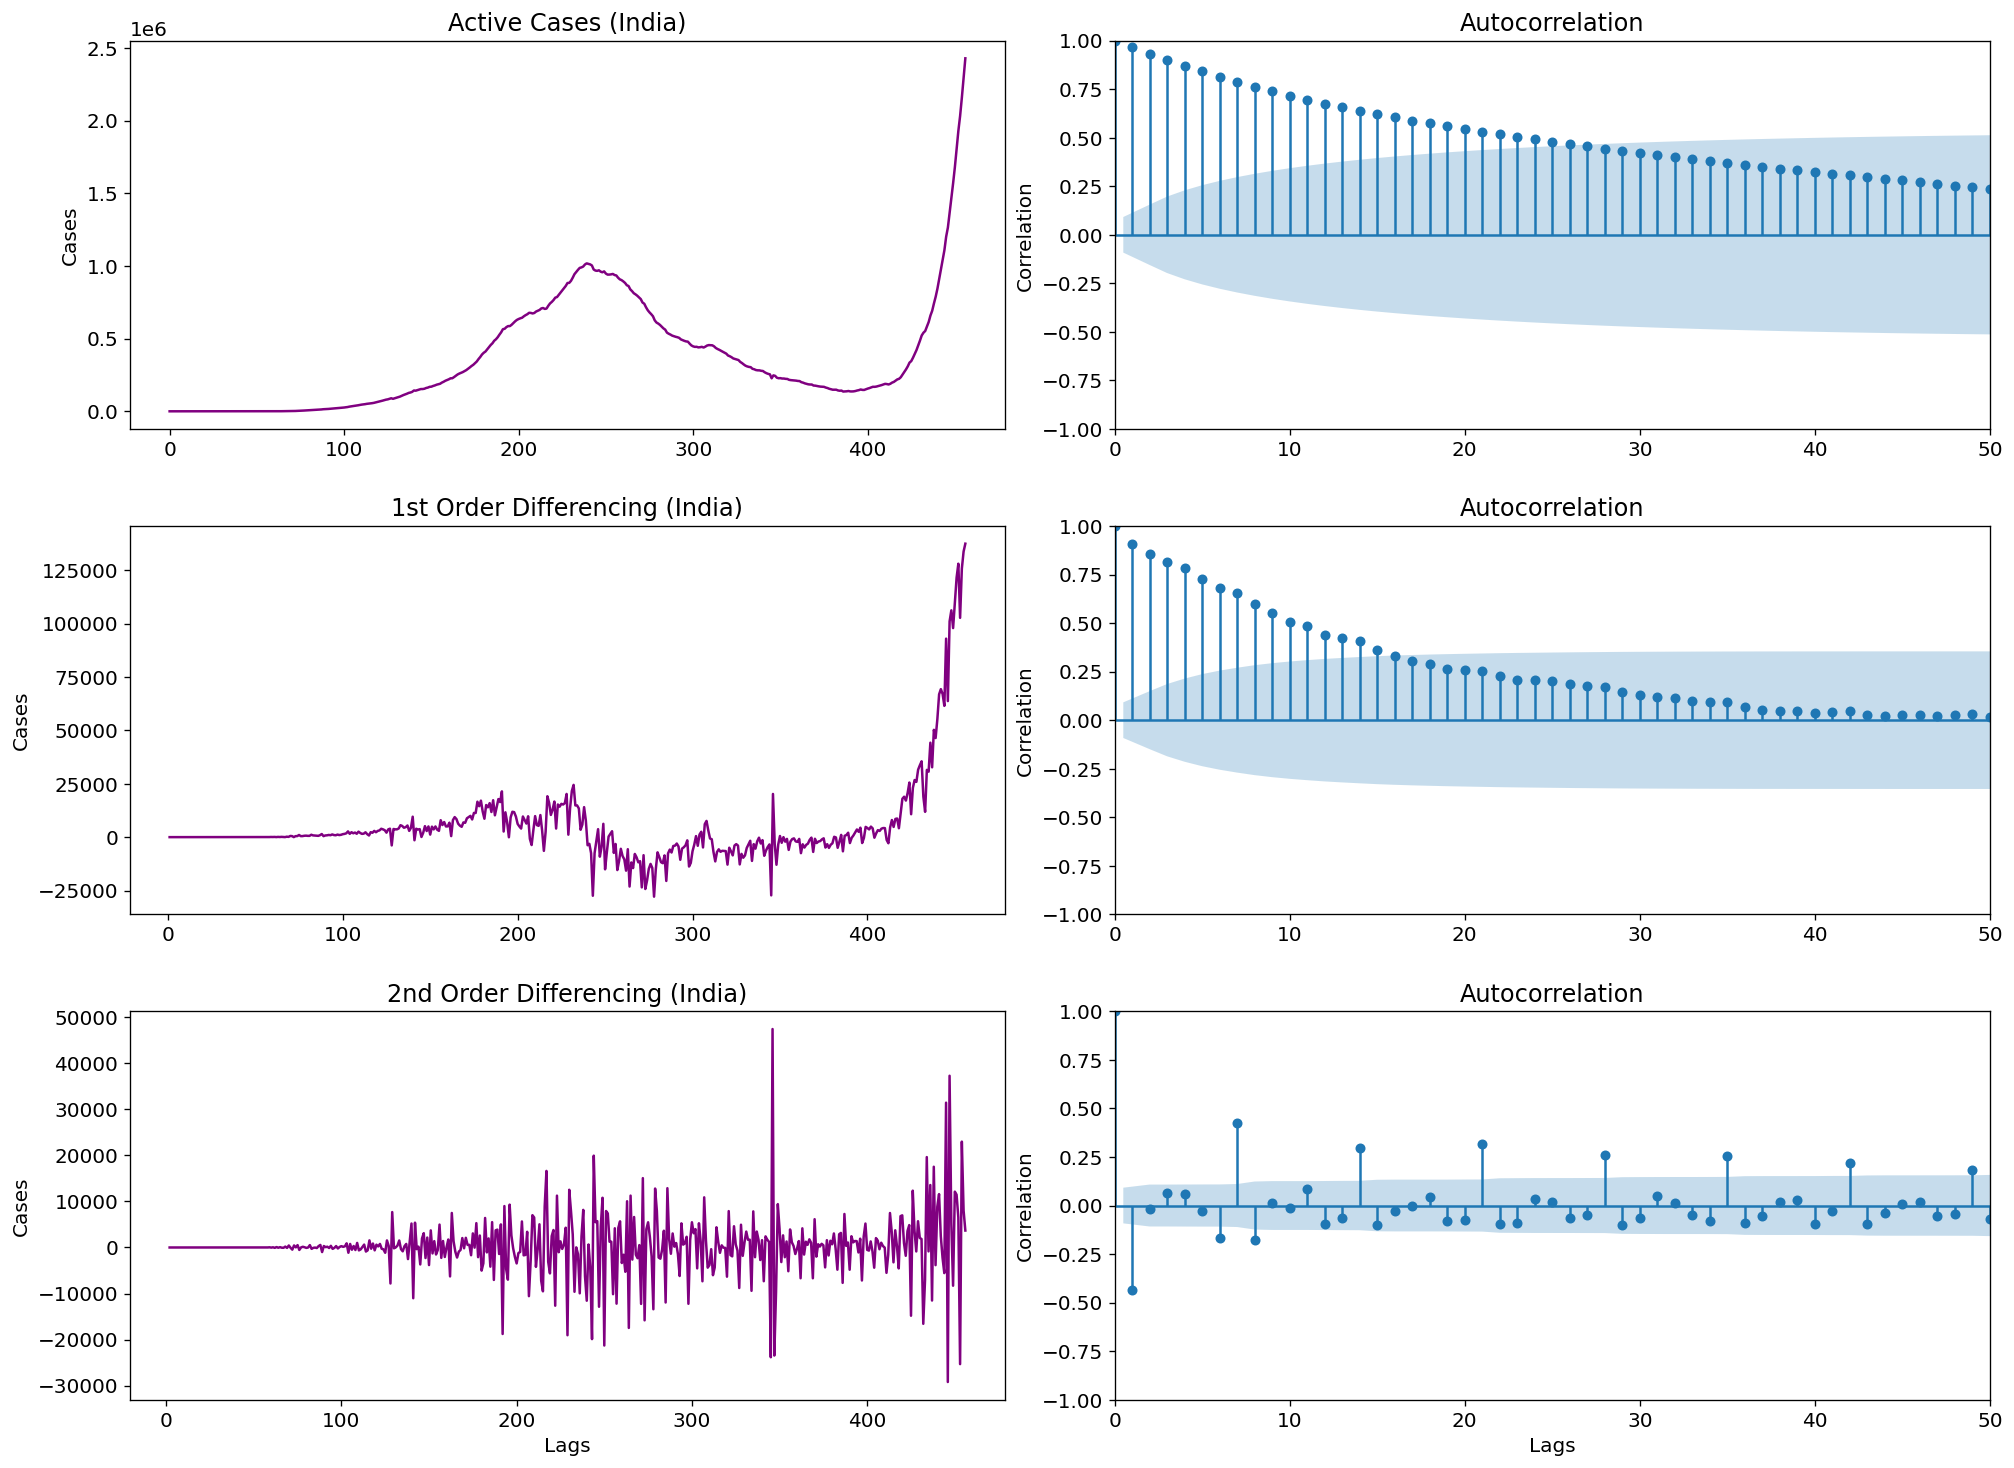

<IPython.core.display.Javascript object>

In [9]:
# Original Series
country = "India"
df = pd.DataFrame(active_train[country].to_numpy())
# df = confirmed_df['India'] #, 'Germany', 'Spain', 'United Kingdom', 'France', 'India', 'Iran', 'Italy', 'Russia', 'Turkey']

fig, axes = plt.subplots(3, 2, figsize=(20, 15))
fig.subplots_adjust(hspace=0.250, wspace=0.125)
axes[0, 0].plot(df, "purple")
axes[0, 0].set(title=f"Active Cases ({country})", ylabel="Cases")
plot_acf(df, ax=axes[0, 1], lags=df.shape[0] - 1)
axes[0, 1].set(ylabel="Correlation", xlim=(0, 50))

# 1st Differencing
axes[1, 0].plot(df.diff(), "purple")
axes[1, 0].set(title=f"1st Order Differencing ({country})", ylabel="Cases")
plot_acf(df.diff().dropna(), ax=axes[1, 1], lags=df.shape[0] - 2)
axes[1, 1].set(ylabel="Correlation", xlim=(0, 50))


# 2nd Differencing
axes[2, 0].plot(df.diff().diff(), "purple")
axes[2, 0].set(
    xlabel="Lags", ylabel="Cases", title=f"2nd Order Differencing ({country})"
)
axes[2, 1].set_xlabel("Lags")
plot_acf(df.diff().diff().dropna(), ax=axes[2, 1], lags=df.shape[0] - 3)
axes[2, 1].set(ylabel="Correlation", xlim=(0, 50))

fig.savefig("Graphs/1.acf_plots.jpg")
plt.show()

For the above series, the time series reaches stationarity with two orders of differencing. But on looking at the autocorrelation plot for the second differencing the lag goes into the far negative zone fairly quick, which indicates, the series might have been over differenced.
$$d = 1 $$

### Determining order of Auto-Regression (p)

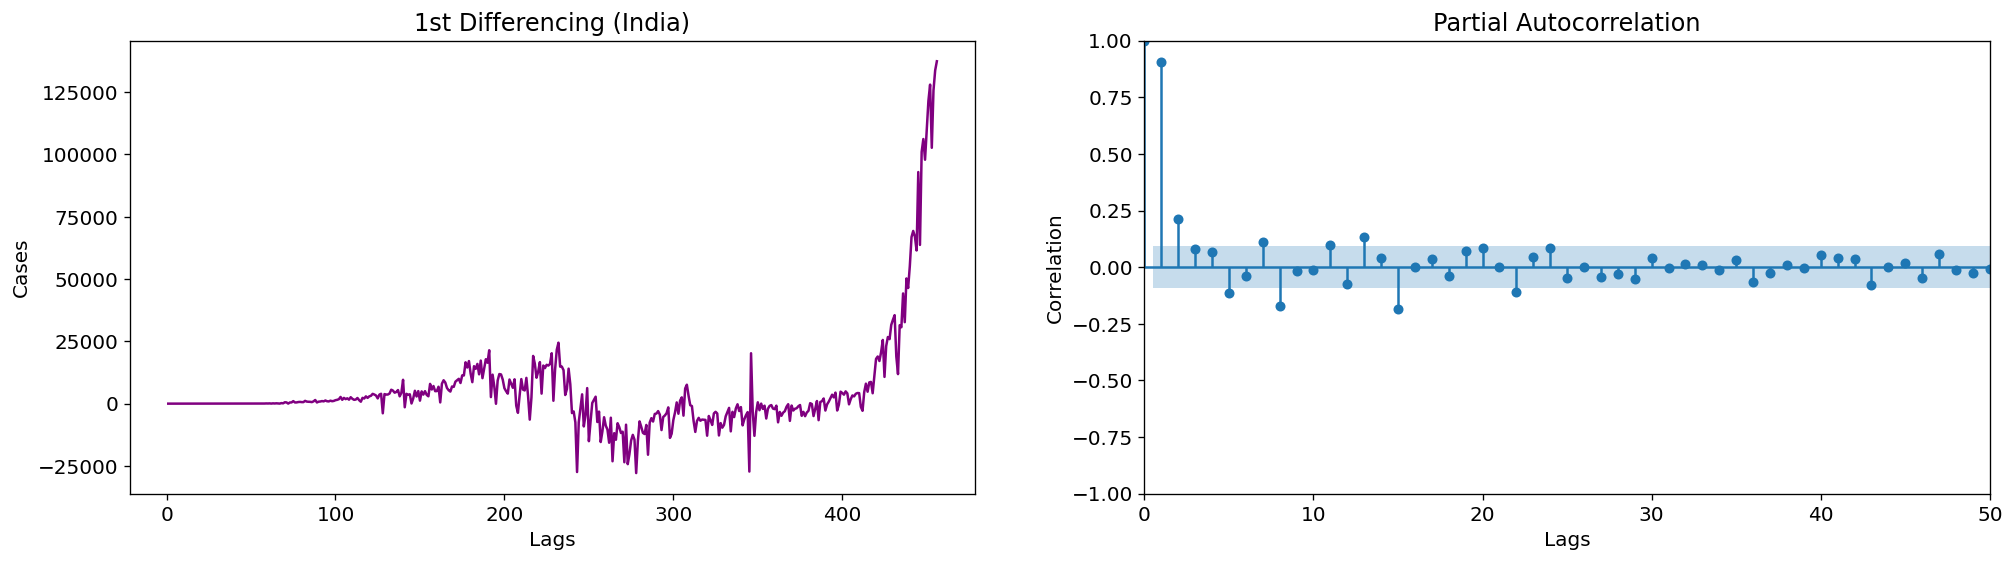

<IPython.core.display.Javascript object>

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 5))
ax1.plot(df.diff(), "purple")
ax1.set(title=f"1st Differencing ({country})", xlabel="Lags", ylabel="Cases")
plot_pacf(df.diff().dropna(), ax=ax2, lags=df.shape[0] / 2 - 1)
ax2.set(xlabel="Lags", ylabel="Correlation", ylim=(-1, 1), xlim=(0, 50))
fig.savefig("Graphs/2.pacf_plots.jpg")
plt.show()

It can observed that the PACF lag 1, 2 and 3 are quite significant since they are well above the significance limit, the blue region.
So we will use:
$$p \in \{1, 2, 3\}$$

### Determining order of Moving Average (q)

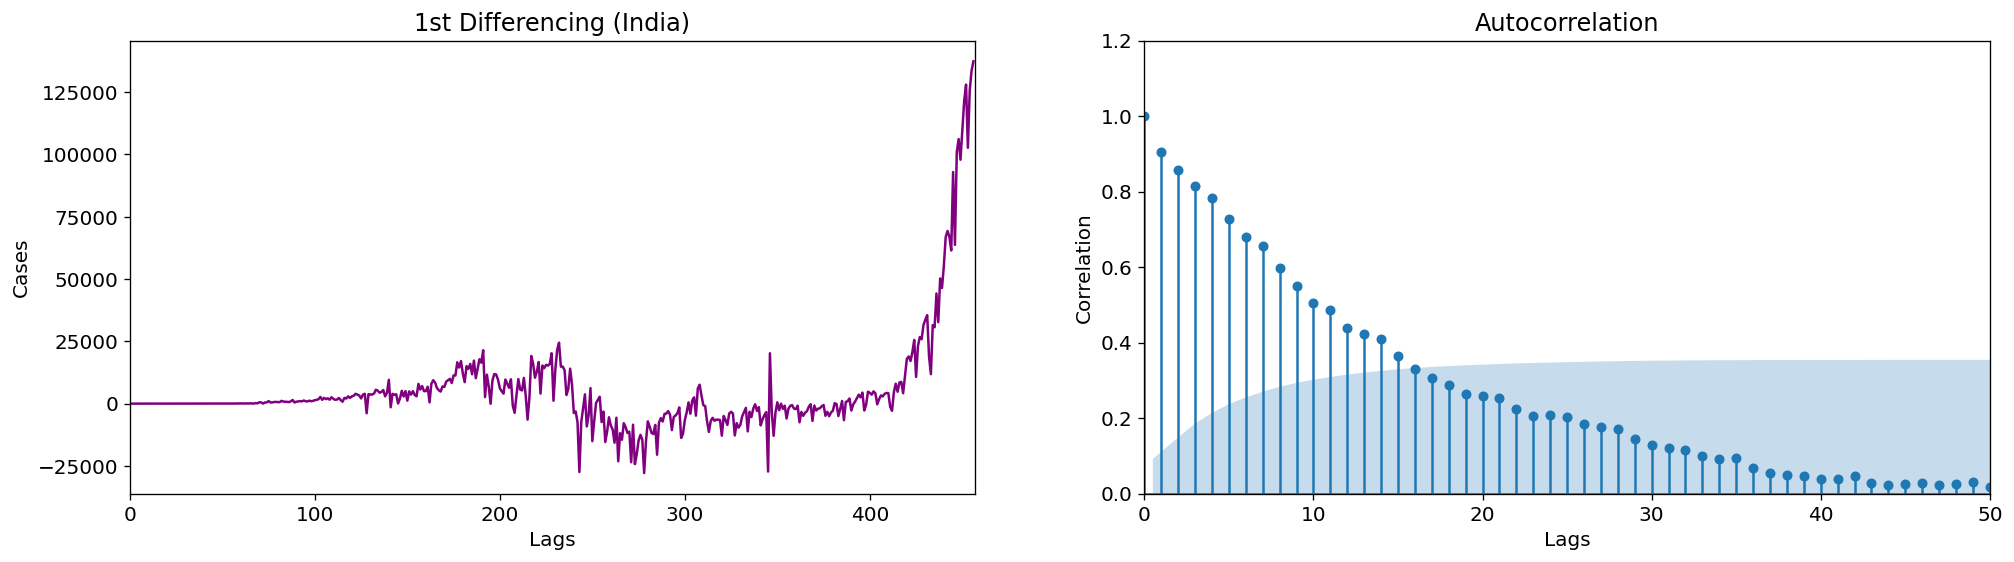

<IPython.core.display.Javascript object>

In [17]:
# fig, axes = plt.subplots(1, 2, sharex=True)
# axes[0].plot(df.diff())
# axes[0].set(title="1st Differencing", ylabel="Cases", xlabel="Lags", xlim=[0, 400])
# plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
# # axes[1].set(ylabel="Correlation", xlabel="Lags", xlim=[0, 50])
fig, axes = plt.subplots(1, 2, figsize=(20, 5))
axes[0].plot(df.diff(), "purple")
axes[0].set(
    title=f"1st Differencing ({country})",
    xlabel="Lags",
    ylabel="Cases",
    xlim=(0, df.shape[0]),
)
plot_acf(df.diff().dropna(), ax=axes[1], lags=df.shape[0] - 2)
axes[1].set(ylim=(0, 1.2), xlim=(0, 50), xlabel="Lags", ylabel="Correlation")

fig.savefig("Graphs/3.acf_plots.jpg")
plt.show()

We can see that upto `lags` = 15, the correlation is above the significance range and so we can conclude that: $$q \in [0, 15]$$

In [12]:
# Define the p, d, q parameters
# p = range(4, 12)
p = range(1, 4)
d = 1
q = range(2, 6)

# Generate all different combinations of p, q and q triplets
# pdq = list(itertools.product(p, d, q))
pdq = [(9, 1, 2), (10, 1, 3), (8, 1, 4), (9, 1, 3)]

print("Examples of parameter combinations for ARIMA...")
print(f"ARIMA: {pdq[0]}")
print(f"ARIMA: {pdq[1]}")
print(f"ARIMA: {pdq[2]}")
print(f"ARIMA: {pdq[3]}")

Examples of parameter combinations for ARIMA...
ARIMA: (9, 1, 2)
ARIMA: (10, 1, 3)
ARIMA: (8, 1, 4)
ARIMA: (9, 1, 3)


<IPython.core.display.Javascript object>

In [13]:
MSE = []
ARIMA_model = []
for param in pdq:
    try:
        mod = sm.tsa.ARIMA(
            active_train["Worldwide"],
            order=param,
            enforce_stationarity=False,
            enforce_invertibility=False,
        )
        results = mod.fit()
        print(f"ARIMA{param} - MSE:{results.mse}", end="\r")
        MSE.append(math.sqrt(results.mse))
        ARIMA_model.append(param)

    except:
        continue

<IPython.core.display.Javascript object>

In [ ]:
print(
    f"The smallest MSE is {min(MSE)} for model ARIMA {ARIMA_model[MSE.index(min(MSE))][0]}x{ARIMA_model[MSE.index(min(MSE))][1]}"
)

In [ ]:
print(ARIMA_model)

In [ ]:
mod = sm.tsa.ARIMA(active_train['Worldwide'],
                                order=ARIMA_model[MSE.index(min(MSE))],
                                enforce_stationarity=False,
                                enforce_invertibility=False)

results = mod.fit()

In [ ]:
results.plot_diagnostics(figsize=(20, 14))
plt.show()